## Predict with Pre-trained Model
  
This notebook shows how to load a pre-trained model and to use this for predicting multi-pitch estimates of an unknown audio file.

&copy; Christof Weiss and Geoffroy Peeters, Télécom Paris 2021

In [1]:
import os
import sys
basepath = os.path.abspath(os.path.dirname(os.path.dirname('.')))
sys.path.append(basepath)
import numpy as np, os, scipy, scipy.spatial, matplotlib.pyplot as plt, IPython.display as ipd
from numba import jit
import librosa
import libfmp.b, libfmp.c3, libfmp.c5
import pandas as pd, pickle, re
from numba import jit
import torch.utils.data
import torch.nn as nn
import libdl.data_preprocessing
from libdl.data_loaders import dataset_context
from libdl.nn_models import basic_cnn_segm_sigmoid, deep_cnn_segm_sigmoid, simple_u_net_largekernels
from libdl.nn_models import simple_u_net_doubleselfattn, simple_u_net_doubleselfattn_twolayers
from libdl.nn_models import u_net_blstm_varlayers, simple_u_net_polyphony_classif_softmax
from libdl.data_preprocessing import compute_hopsize_cqt, compute_hcqt, compute_efficient_hcqt, compute_annotation_array_nooverlap
from torchinfo import summary

### 1. Specify and load model (Example)

In [2]:
dir_models = os.path.join(basepath, 'models_pretrained')
num_octaves_inp = 6
num_output_bins, min_pitch = 72, 24


# Polyphony U-Net trained in recommended MusicNet split (test set MuN-10full):
model_params = {'n_chan_input': 6,
                'n_chan_layers': [128,180,150,100],
                'n_ch_out': 2,
                'n_bins_in': num_octaves_inp*12*3,
                'n_bins_out': num_output_bins,
                'a_lrelu': 0.3,
                'p_dropout': 0.2,
                'scalefac': 2,
                'num_polyphony_steps': 24
                }
mp = model_params

fn_model = 'RETRAIN4_exp195f_musicnet_aligned_unet_extremelylarge_polyphony_softmax_rerun1.pt'
model = simple_u_net_polyphony_classif_softmax(n_chan_input=mp['n_chan_input'], n_chan_layers=mp['n_chan_layers'], \
    n_bins_in=mp['n_bins_in'], n_bins_out=mp['n_bins_out'], a_lrelu=mp['a_lrelu'], p_dropout=mp['p_dropout'], \
    scalefac=mp['scalefac'], num_polyphony_steps=mp['num_polyphony_steps'])


path_trained_model = os.path.join(dir_models, fn_model)

model.load_state_dict(torch.load(path_trained_model, map_location=torch.device('cpu')))

model.eval()
summary(model, input_size=(1, 6, 174, 216))

Layer (type:depth-idx)                   Output Shape              Param #
├─LayerNorm: 1-1                         [1, 174, 6, 216]          2,592
├─double_conv: 1-2                       [1, 32, 174, 216]         --
|    └─Sequential: 2-1                   [1, 32, 174, 216]         --
|    |    └─Conv2d: 3-1                  [1, 32, 174, 216]         43,232
|    |    └─BatchNorm2d: 3-2             [1, 32, 174, 216]         64
|    |    └─ReLU: 3-3                    [1, 32, 174, 216]         --
|    |    └─Dropout: 3-4                 [1, 32, 174, 216]         --
|    |    └─Conv2d: 3-5                  [1, 32, 174, 216]         230,432
|    |    └─BatchNorm2d: 3-6             [1, 32, 174, 216]         64
|    |    └─ReLU: 3-7                    [1, 32, 174, 216]         --
|    |    └─Dropout: 3-8                 [1, 32, 174, 216]         --
├─Sequential: 1-3                        [1, 64, 87, 108]          --
|    └─MaxPool2d: 2-2                    [1, 32, 87, 108]          --
|  

### 2. Load Test Audio and compute HCQT

In [3]:
fs = 22050

audio_folder = os.path.join(basepath, 'data', 'MusicNet', 'audio')
fn_audio = '2382_Beethoven_OP130_StringQuartet.wav'

path_audio = os.path.join(audio_folder, fn_audio)
f_audio, fs_load = librosa.load(path_audio, sr=fs)

bins_per_semitone = 3
num_octaves = 6
n_bins = bins_per_semitone*12*num_octaves
num_harmonics = 5
num_subharmonics = 1
center_bins=True

f_hcqt, fs_hcqt, hopsize_cqt = compute_efficient_hcqt(f_audio, fs=22050, fmin=librosa.note_to_hz('C1'), fs_hcqt_target=50, \
                                                    bins_per_octave=bins_per_semitone*12, num_octaves=num_octaves, \
                                                    num_harmonics=num_harmonics, num_subharmonics=num_subharmonics, center_bins=True)

### 3. Predict Pitches

In [4]:
# Set test parameters
test_params = {'batch_size': 1,
              'shuffle': False,
              'num_workers': 1
              }
device = 'cpu'

test_dataset_params = {'context': 75,
                       'stride': 1,
                       'compression': 10
                      }
half_context = test_dataset_params['context']//2

inputs = np.transpose(f_hcqt, (2, 1, 0))
targets = np.zeros(inputs.shape[1:]) # need dummy targets to use dataset object

inputs_context = torch.from_numpy(np.pad(inputs, ((0, 0), (half_context, half_context+1), (0, 0))))
targets_context = torch.from_numpy(np.pad(targets, ((half_context, half_context+1), (0, 0))))

test_set = dataset_context(inputs_context, targets_context, test_dataset_params)
test_generator = torch.utils.data.DataLoader(test_set, **test_params)

pred_tot = np.zeros((0, num_output_bins))

max_frames = 160
k=0
for test_batch, test_labels in test_generator:
    k+=1
    if k>max_frames:
        break
    # Model computations
    y_pred, n_pred = model(test_batch)
    pred_log = torch.squeeze(torch.squeeze(y_pred.to('cpu'),2),1).detach().numpy()
    # pred_log = torch.squeeze(y_pred.to('cpu')).detach().numpy()
    pred_tot = np.append(pred_tot, pred_log, axis=0)
    
predictions = pred_tot

print(predictions.shape)

(160, 72)


### 4. Plot Predictions and Annotations (Ground truth)

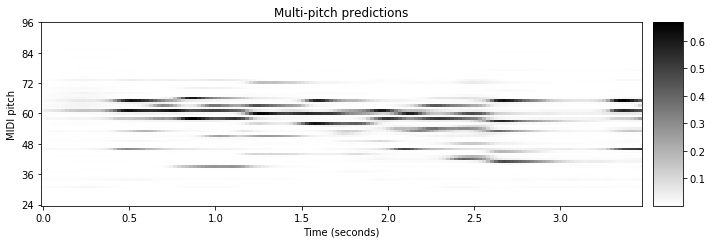

In [5]:
start_sec = 0
show_sec = 3.5

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 0.05]}, figsize=(10, 3.5))
im = libfmp.b.plot_matrix(predictions.T[:, int(start_sec*fs_hcqt):int(show_sec*fs_hcqt)], Fs=fs_hcqt, ax=ax, cmap='gray_r', ylabel='MIDI pitch')
ax[0].set_yticks(np.arange(0, 73, 12))
ax[0].set_yticklabels([str(24+12*octave) for octave in range(0, num_octaves+1)])
ax[0].set_title('Multi-pitch predictions')
plt.tight_layout()

### 6. Compare with annotations

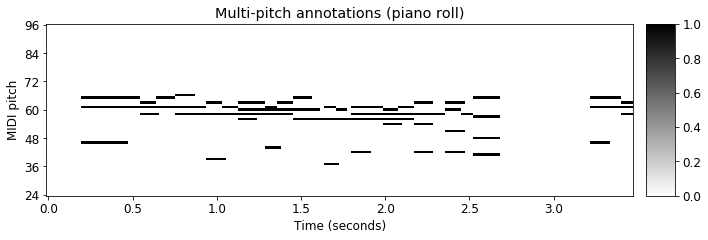

In [6]:
annot_folder = os.path.join(basepath, 'data', 'MusicNet', 'csv')
fn_annot = os.path.join(annot_folder, fn_audio[:-4]+'.csv')

df = pd.read_csv(fn_annot, sep=',')
note_events = df.to_numpy()[:,(0,1,3)]
note_events[:,:2] /= 44100
note_events = np.append(note_events, np.zeros((note_events.shape[0], 1)), axis=1)
        
f_annot_pitch = compute_annotation_array_nooverlap(note_events.copy(), f_hcqt, fs_hcqt, annot_type='pitch', shorten=1.0)
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 0.05]}, figsize=(10, 3.5))

cfig, cax, cim = libfmp.b.plot_matrix(f_annot_pitch[24:97, int(start_sec*fs_hcqt):int(show_sec*fs_hcqt)], ax=ax, Fs=fs_hcqt, cmap='gray_r', ylabel='MIDI pitch')
plt.ylim([0, 73])
ax[0].set_yticks(np.arange(0, 73, 12))
ax[0].set_yticklabels([str(24+12*octave) for octave in range(0, num_octaves+1)])
ax[0].set_title('Multi-pitch annotations (piano roll)')
ax[1].set_ylim([0, 1])
plt.tight_layout()